In [1]:
#initialise and import CAMB

#plots
from matplotlib import pyplot as plt
import pylab as pl
%matplotlib inline

#run system 
import sys, platform, os

#arrays and scientific
import numpy as np
pi=np.pi
#from scipy import integrate
#from scipy import linalg
import scipy
from scipy.interpolate import splrep, splev
from scipy.interpolate import interp1d #, interp2d

#CAMB
import camb
from camb import model, initialpower

In [2]:
# General plotting things
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['legend.fontsize']='medium'

In [3]:
#Fiducial cosmological parameters
c=3e5
hubble=0.678
omegab=0.022*pow(hubble,-2)
omegac=0.119*pow(hubble,-2)
om0=omegac+omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.968
gamma=0.545

In [4]:
#Set up the fiducial cosmology
pars = camb.CAMBparams()
#Set cosmology
pars.set_cosmology(H0=H00, ombh2=omegab*pow(hubble,2), omch2=omegac*pow(hubble,2),omk=0,mnu=0)
pars.set_dark_energy() #LCDM (default)
pars.InitPower.set_params(ns=nss, r=0, As=Ass)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#Clean bands
bands_z=np.array([[0.34,0.47],[0.22,0.34],[0.0,0.092]])
zc=(bands_z[:,1]+bands_z[:,0])/2
Delta_z=bands_z[:,1]-bands_z[:,0]
print(zc)
print(Delta_z)

[ 0.405  0.28   0.046]
[ 0.13   0.12   0.092]


In [6]:
#number density of galaxies: rough estimate
#N1=((3.8+2.2)/2*(0.41-0.34)+(2.2+3.5)/2*(0.47-0.41))*1e-4/hubble**3 #Mpc^-3
#N2=((4.2+3.0)/2*(0.28-0.22)+(3.0+3.8)/2*(0.34-0.28))*1e-4/hubble**3 #Mpc^-3
#n_gal_den=np.array([N1,N2])
#print(n_gal_den)

In [7]:
1e-4*hubble
10*hubble

6.78

In [8]:
#Get matter power spectrum at z: P(k,z)

def get_pk(z_in):
    #Not non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[z_in], kmax=2.0)
    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints = 200)
    
    return kh, pk

def Pk_noh(z,hubble,kk):
    kh, pk = get_pk(z)
    Pkz=interp1d(kh*hubble, pk[0]/pow(hubble,3))
    return Pkz(kk)
    

In [9]:
#HI parameters

#fiducial bHI fit, SKA Red Book
def bHI(zc):
    return 0.67+0.18*zc+0.05*pow(zc,2)

#fiducial OmHI, SKA Red Book
def OmHI(zc):
    return 0.00048+0.00039*zc-0.000065*pow(zc,2)

#mean brightness temperature [mK], SKA Red Book
def Tb(zc):
    return 0.0559+0.2324*zc-0.024*pow(zc,2)

#Construct P_HI(k,z) [mK^2]
def PHI(kk,zc,hubble):
    return Tb(zc)**2*bHI(zc)**2*Pk_noh(zc,hubble,kk)

In [10]:
#gal parameters parameters

#fiducial bgal
def bg(zc):
    return np.sqrt(1+zc)

#Construct PHIg(k,z) [mK]
def PHIg(kk,zc,hubble):    
    return Tb(zc)*bHI(zc)*bg(zc)*Pk_noh(zc,hubble,kk)

#Construct PHIg(k,z) 
def Pg(kk,zc,hubble):    
    return bg(zc)**2*Pk_noh(zc,hubble,kk)


In [11]:
# Volumes

#Redshift bin
#Define E(z) = H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))

#Define the comoving distance
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)
def DA(zc):
    return rcom(zc)/(1+zc)

def fc(zc):
    return 1420.4/(1+zc)



In [12]:
### telescope definitions

#MK Science Verification (SV) noise specs
Ndishes=16
Ddish=13.5*100 #cm
Nbeams=1

def thetab(zc):
    return 1.22*21*(1+zc)/Ddish

def omegapix(zc):
    return 1.13*pow(thetab(zc),2)

nu, Tsys_eta=np.loadtxt('Tsys_eta_MeerKAT_Lband[MHz_K].txt',unpack=True)

def Tsys_mk(zc):
    T_sys_meerkat_rep=splrep(nu,Tsys_eta)
    T_sys_meerkat=splev(fc(zc),T_sys_meerkat_rep)*1e3
    return T_sys_meerkat
    
Trcv = 25.0*1e3
#sky temperature
def Tsky(zc):
    return 60*pow(300/fc(zc),2.55)*1e3

In [13]:
# survey details and noise 

Area=300.0 #deg^2
omegatot = Area*pow(pi/180,2) #Sr
ttotal = 30*60*60 #30 hrs

dfpix = 50*1e3 #Hz
midfreq = 1420.4e6 #Hz

#total observation time
def tobs(zc):
    return ttotal*(omegapix(zc)/omegatot)*Ndishes*Nbeams

#redshift resoltuion
def dzpix(zc):
    return pow(1+zc,2)*dfpix/midfreq

#sensitivity in each pixel
def sigpix(zc,Tsys):
    return Tsys/np.sqrt(2*dfpix*tobs(zc))

#pixel volume
def dVpixdz(zz):    
    return c*pow(rcom(zz),2)/(H00*Ez(zz))
def Vpix(zc):
    return omegapix(zc)*scipy.integrate.romberg(dVpixdz,zc-dzpix(zc)/2,zc+dzpix(zc)/2)

#window to include beam effects 
# it is in terms of k_|| but for now we can put it in terms of k
def Wsq(kk,mu,zc):
    #add very small offset to avoid division by zero
    return 1e-20+np.exp(-pow(kk,2)*(1-mu**2)*pow(rcom(zc),2)*pow(thetab(zc),2)/(8*np.log(2)))

def Pnoise_mu(mu,kk,zc,Tsys):
    return pow(sigpix(zc,Tsys),2)*Vpix(zc)*pow(Wsq(kk,mu,zc),-1.)

#angle averaged noise
def Pnoise(kk,zc,Tsys):
    try:
        len(kk)
    except TypeError:
        return scipy.integrate.quad(Pnoise_mu,0,1,args=(kk,zc,Tsys))[0]
    else:
        raise Exception('kk should be a scalar, dummy!')     
        
## We will make mu=0 for now

In [14]:
#survey (bin) volume [Mpc^3]
def dVsurdz(zz):    
    return c*pow(rcom(zz),2)/(H00*Ez(zz))
    
def Vsur(zc,Dzbin,omega):
    return scipy.integrate.romberg(dVsurdz,zc-Dzbin/2,zc+Dzbin/2)*omega

def Veff(kk,zc,Dzbin,omega,include_RSD=False):
    if include_RSD==True:
        return Vsur(zc,Dzbin,omega)*(PHI(kk,zc)/(PHI(kk,zc)+Pnoise(kk,zc,Tsys)))**2
    else:
        return Vsur(zc,Dzbin,omega)*(PHI(kk,zc)/(PHI(kk,zc)+Pnoise_mu(0,kk,zc,Tsys)))**2

print("%.4g" % Vsur(0.3,0.1,0.2))

1.153e+08


In [15]:
# Number of galaxies
zi,zf, Ngal_b= np.loadtxt('sdss_all_small_dr14_hist.asc',unpack=True)
n_gal=np.zeros(len(zc))
omega_sdss=9329*(pi/180)**2
for i in range(len(zc)):
    index_i=np.argwhere(zi==bands_z[i,0])[0,0]
    index_o=np.argwhere(zi>=bands_z[i,1])[0,0]
    N_gal=sum(Ngal_b[index_i:index_o])
    n_gal[i]=N_gal/Vsur(zc[i],Delta_z[i],omega_sdss)
    
print(n_gal)

[ 0.00010376  0.00013793  0.00640279]


In [16]:
#k to include
def kmin(zc,Dzbin,omega):
    #return 2*pi/np.sqrt(pow(rcom(zc),2)*omegatot)
    return 2*pi*pow(Vsur(zc,Dzbin,omega),-1/3)
def kmax(zc):
    return 2*pi*Ddish/(rcom(zc)*1.22*21*(1+zc)) #instrumental cutoff
    
def kmax_NL(zc):#this should be used in the Fisher Matrix for linear scales only    
    return 0.14*pow(1+zc,2/(2+nss)); #non-linear cutoff, Smith et al 2003

def PHIerr(kk,zc,Tsys,omega,include_RSD=False):
    if include_RSD==True:
        return np.sqrt((2*(2*pi)**3/Vsur(zc,Dzbin,omega))*(1/(4*pi*kk**2*deltak)))*(PHI(kk,zc,hubble)+Pnoise(kk,zc,Tsys))
    else:
        return np.sqrt((2*(2*pi)**3/Vsur(zc,Dzbin,omega))*(1/(4*pi*kk**2*deltak)))*(PHI(kk,zc,hubble)+Pnoise_mu(0,kk,zc,Tsys))

In [17]:
#galaxies and Xgal noises

#shot noise of the galaxies
def Pshot(ngal): #shot noise
    return 1/ngal

def PHIgerr(kk,zc,Dzbin,omega,hubble,ngal,deltak):
    return np.sqrt(4*pi**2/(Vsur(zc,Dzbin,omega)*kk**2*deltak))*np.sqrt(pow(PHIg(kk,zc,hubble),2)+
                                                            (PHI(kk,zc,hubble)+Pnoise_mu(0,kk,zc,Tsys_mk(zc)))*
                                                                  (Pg(kk,zc,hubble)+Pshot(ngal)))

In [18]:

def plot_pk_z_bin(zc,Dzbin,ngal,area):
    #k-bin
    omega=area*(np.pi/180)**2
    
    deltak=round(kmin(zc,Dzbin,omega),3)
    
    #theory
    k1 = 10**np.arange(-3,0,0.1)
    pk1 = PHIg(k1,zc,hubble)
    
    #k-binned pk and error
    k1list = np.arange(kmin(zc,Dzbin,omega)+deltak/2,kmax(zc),deltak)
    pk1list = PHIg(k1list,zc,hubble) 
    pk1error = PHIgerr(k1list,zc,Dzbin,omega,hubble,ngal,deltak)
    
    #plot
    pl.xscale('log')
    pl.yscale('log')
    pl.plot(k1, pk1, color='black',lw=2)
    pl.errorbar(k1list, pk1list, xerr=deltak/2,yerr=pk1error, fmt='o', color='black')
    
    pk_max1=np.amax(pk1list+pk1error)
    pk_max2=np.amax(pk1)
    pk_max=max(pk_max1,pk_max2)
    pl.xlim(6e-3,kmax(zc)*1.2)
    pl.ylim(0.3*np.amin(pk1list),pk_max*1.5)
    
    pl.xlabel("$k \, \mathrm{[Mpc^{-1}]}$")
    pl.ylabel("$P_{\, \mathrm{HIg}}(k) \, \mathrm{[mK\ Mpc^3]}$")
    
    pl.text(k1list[0]+deltak/2,pk_max/1.3,'$z=%0.2f, \Delta z = %0.2f$' %(zc,Dzbin))
    pl.text(1e-2,0.3*np.amin(pk1list)*1.3,'16 dishes, '+str(area)+' sq deg, 30 hrs')
    
    pl.savefig('PHIg_MK_BOSS_SV_'+str(area)+'deg'+str(zc)+'.jpg', format="jpg", bbox_inches = 'tight')
    pl.show()

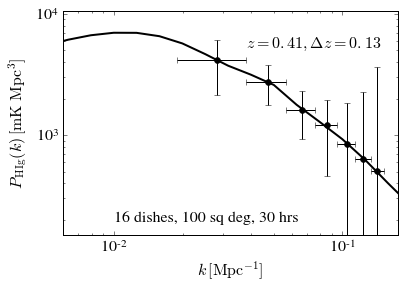

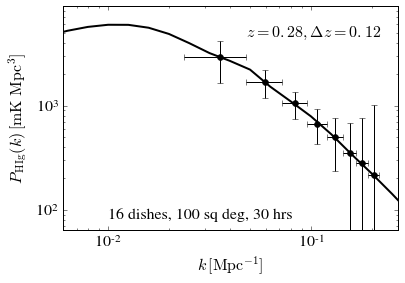

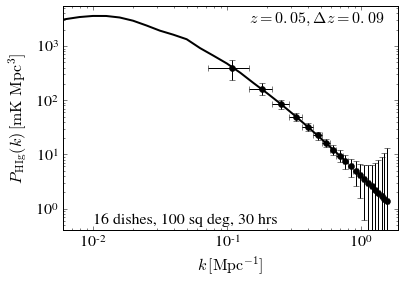

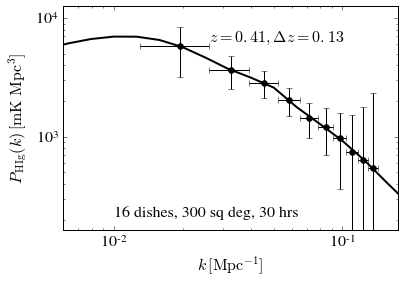

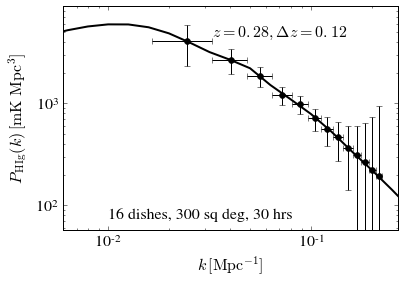

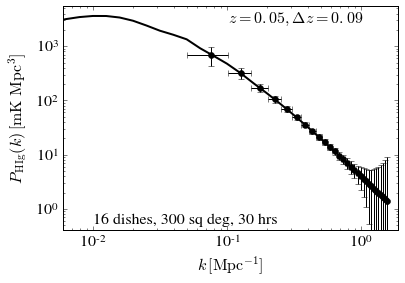

In [19]:
Area=[100,300]
for j in range(len(Area)):
    for i in range(len(zc)):
        plot_pk_z_bin(zc[i],Delta_z[i],n_gal[i],Area[j])

In [20]:
def snr(zc,Dzbin,ngal,area):
    omega=area*(np.pi/180)**2
    #k-bin
    deltak=round(kmin(zc,Dzbin,omega),3)    
    #k-binned pk and error
    k1list = np.arange(kmin(zc,Dzbin,omega)+deltak/2,kmax(zc),deltak)   
    pk1list = PHIg(k1list,zc,hubble) 
    pk1error = PHIgerr(k1list,zc,Dzbin,omega,hubble,ngal,deltak)  
    snr_k=(pk1list/pk1error)**2
    SNR=np.sqrt(sum(snr_k))
    return SNR

In [21]:
for j in range(len(Area)):
    for i in range(len(zc)):
        print(Area[j],':',zc[i],':',snr(zc[i],Delta_z[i],n_gal[i],Area[j]))

100 : 0.405 : 4.57858589806
100 : 0.28 : 6.37814991013
100 : 0.046 : 16.3931609595
300 : 0.405 : 8.0087748391
300 : 0.28 : 11.1037076644
300 : 0.046 : 28.4218012129
